# Парсер вакасий с HH.ru

In [26]:
import requests
import pandas as pd
import numpy as np

import json

from datetime import datetime, timedelta
import time
import os
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets
from typing import Union 

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
BASE_URL = "https://api.hh.ru/"

#TEXT = f'NAME:("Machine Learning Engineer" OR "Data Scientist" OR "Дата саентист" OR "Machine Learning Developer" or "Machine Learning Researcher" or "Искусственный интеллект" or "Машинное обучение" or "Специалист по machine learning" or "Специалист по машинному обучению" or "AI engineer" or "Разработчик ML" or "Data Science" or "Machine Learning" or "Artificial Intelligence" or "ML Engineer" or "Аналитик" or "Analyst" or "Data Engineer" or "DWH" or "BI" or "Business Intelligence" or "Data инженер" or "Инженер данных" or "ETL" or "КХД")'
TEXT = f'SQL NAME:("Аналитик" or "Analyst" or "DWH" or "BI" or "Business Intelligence" or "ETL" or "КХД")'

dt_now = datetime.now().date()
dt_from = dt_now - timedelta(days=7)
DATE_TO = dt_now.isoformat() #API требует дату в формате ISO 8601 YYYY-MM-DD или YYYY-MM-DDThh:mm:ss±hhmm
DATE_FROM = dt_from.isoformat()

VAC_URL = BASE_URL + f'vacancies?text={TEXT}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'

Cоздаем датафрейм в который будем сохранять наши данные:

In [28]:
df = pd.DataFrame()

Через переменную experience зададим тербуемый опыт работы в выдаче:

In [34]:
experience = ['noExperience',
              'between1And3',
              'between3And6',
              'moreThan6']

In [35]:
for exp in experience:
    page = 0
    url = VAC_URL + f'&experiences={exp}'
    try:
        r = requests.get(url+f'&page={page}')
        data = json.loads(r.text)
        print(exp, ' - ', data['pages'])
        items = data['items']
        for page in range(1, data['pages']):
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text)
            items += data['items']
        df = pd.DataFrame(items)
        df['experience'] = exp
        vacancy_df = pd.concat([vacancy_df, df])
    except Exception as e:
        print(e)
        time.sleep(5)

noExperience  -  20
between1And3  -  20
between3And6  -  20
moreThan6  -  20


In [36]:
vacancy_df.head(5)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,depatment_name,salary_from,salary_to,salary_gross,salary_currency,responses,city
0,52336670,False,Analyst,None,False,False,"{'id': '115', 'name': 'Киев', 'url': 'https://...","{'from': 1000, 'to': 3000, 'currency': 'USD', ...","{'id': 'anonymous', 'name': 'Анонимная'}",None,None,None,2022-02-11T14:31:56+0300,2022-02-11T14:31:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52336670?host=hh.ru,https://hh.ru/vacancy/52336670,[],{'name': 'European Consulting Group'},{'requirement': 'Qualifications: Relevant univ...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],True,noExperience,European Consulting Group,NaN,1000.0,3000.0,True,USD,1.0,Киев
1,52341839,False,Junior BI Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 70000, 'to': 90000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Рязанский проспе...",None,None,2022-02-11T16:10:36+0300,2022-02-11T16:10:36+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52341839?host=hh.ru,https://hh.ru/vacancy/52341839,[],"{'id': '13', 'name': 'WiseAdvice', 'url': 'htt...",{'requirement': 'Знание <highlighttext>SQL</hi...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 24},[],[],[],False,noExperience,WiseAdvice,NaN,70000.0,90000.0,False,RUR,24.0,Москва
2,49832942,False,Аналитик,"{'id': '2343-2343-it', 'name': 'Компания «СПОР...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T13:26:27+0300,2022-02-11T13:26:27+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/49832942?host=hh.ru,https://hh.ru/vacancy/49832942,[],"{'id': '2343', 'name': 'Спортмастер', 'url': '...",{'requirement': 'Понимание построения информац...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 10},[],[],[],False,noExperience,Спортмастер,"Компания «СПОРТМАСТЕР», SM Lab",NaN,NaN,NaN,NaN,10.0,Москва
3,52029380,False,Аналитик,None,False,False,"{'id': '1375', 'name': 'Нижневартовск', 'url':...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T12:22:56+0300,2022-02-11T12:22:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52029380?host=hh.ru,https://hh.ru/vacancy/52029380,[],"{'id': '941566', 'name': 'КОМТЕК', 'url': 'htt...",{'requirement': '...с <highlighttext>SQL</high...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 111},[],[],[],False,noExperience,КОМТЕК,NaN,55000.0,NaN,False,RUR,111.0,Нижневартовск
4,52029381,False,Аналитик,None,False,False,"{'id': '99', 'name': 'Уфа', 'url': 'https://ap...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T12:22:56+0300,2022-02-11T12:22:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52029381?host=hh.ru,https://hh.ru/vacancy/52029381,[],"{'id': '941566', 'name': 'КОМТЕК', 'url': 'htt...",{'requirement': '...с <highlighttext>SQL</high...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 60},[],[],[],False,noExperience,КОМТЕК,NaN,55000.0,NaN,False,RUR,60.0,Уфа


In [37]:
vacancy_df.reset_index(drop=True, inplace=True)

In [38]:
vacancy_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,depatment_name,salary_from,salary_to,salary_gross,salary_currency,responses,city
0,52336670,False,Analyst,None,False,False,"{'id': '115', 'name': 'Киев', 'url': 'https://...","{'from': 1000, 'to': 3000, 'currency': 'USD', ...","{'id': 'anonymous', 'name': 'Анонимная'}",None,None,None,2022-02-11T14:31:56+0300,2022-02-11T14:31:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52336670?host=hh.ru,https://hh.ru/vacancy/52336670,[],{'name': 'European Consulting Group'},{'requirement': 'Qualifications: Relevant univ...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],True,noExperience,European Consulting Group,NaN,1000.0,3000.0,True,USD,1.0,Киев
1,52341839,False,Junior BI Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 70000, 'to': 90000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Рязанский проспе...",None,None,2022-02-11T16:10:36+0300,2022-02-11T16:10:36+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52341839?host=hh.ru,https://hh.ru/vacancy/52341839,[],"{'id': '13', 'name': 'WiseAdvice', 'url': 'htt...",{'requirement': 'Знание <highlighttext>SQL</hi...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 24},[],[],[],False,noExperience,WiseAdvice,NaN,70000.0,90000.0,False,RUR,24.0,Москва
2,49832942,False,Аналитик,"{'id': '2343-2343-it', 'name': 'Компания «СПОР...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T13:26:27+0300,2022-02-11T13:26:27+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/49832942?host=hh.ru,https://hh.ru/vacancy/49832942,[],"{'id': '2343', 'name': 'Спортмастер', 'url': '...",{'requirement': 'Понимание построения информац...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 10},[],[],[],False,noExperience,Спортмастер,"Компания «СПОРТМАСТЕР», SM Lab",NaN,NaN,NaN,NaN,10.0,Москва
3,52029380,False,Аналитик,None,False,False,"{'id': '1375', 'name': 'Нижневартовск', 'url':...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T12:22:56+0300,2022-02-11T12:22:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52029380?host=hh.ru,https://hh.ru/vacancy/52029380,[],"{'id': '941566', 'name': 'КОМТЕК', 'url': 'htt...",{'requirement': '...с <highlighttext>SQL</high...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 111},[],[],[],False,noExperience,КОМТЕК,NaN,55000.0,NaN,False,RUR,111.0,Нижневартовск
4,52029381,False,Аналитик,None,False,False,"{'id': '99', 'name': 'Уфа', 'url': 'https://ap...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T12:22:56+0300,2022-02-11T12:22:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52029381?host=hh.ru,https://hh.ru/vacancy/52029381,[],"{'id': '941566', 'name': 'КОМТЕК', 'url': 'htt...",{'requirement': '...с <highlighttext>SQL</high...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 60},[],[],[],False,noExperience,КОМТЕК,NaN,55000.0,NaN,False,RUR,60.0,Уфа
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11147,51086603,False,Market Intelligence Analyst,None,False,False,"{'id': '115', 'name': 'Киев', 'url': 'https://...",None,"{

In [10]:
def return_id(x, key = 'id', nan_value=np.nan):
    try:
        return x[key]
    except Exception as e:
        return nan_value  

In [11]:
vacancy_df['employer_name'] = vacancy_df['employer'].apply(return_id, key = 'name')
vacancy_df['depatment_name'] = vacancy_df['department'].apply(return_id, key='name')
vacancy_df['salary_from'] = vacancy_df['salary'].apply(return_id, key='from')
vacancy_df['salary_to'] = vacancy_df['salary'].apply(return_id, key='to')
vacancy_df['salary_gross'] = vacancy_df['salary'].apply(return_id, key='gross')
vacancy_df['salary_currency'] = vacancy_df['salary'].apply(return_id, key='currency')
vacancy_df['responses'] = vacancy_df['counters'].apply(return_id, key='responses')
vacancy_df['city'] = vacancy_df['area'].apply(return_id, key='name')

In [12]:
vacancy_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,depatment_name,salary_from,salary_to,salary_gross,salary_currency,responses,city
0,52336670,False,Analyst,None,False,False,"{'id': '115', 'name': 'Киев', 'url': 'https://...","{'from': 1000, 'to': 3000, 'currency': 'USD', ...","{'id': 'anonymous', 'name': 'Анонимная'}",None,None,None,2022-02-11T14:31:56+0300,2022-02-11T14:31:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52336670?host=hh.ru,https://hh.ru/vacancy/52336670,[],{'name': 'European Consulting Group'},{'requirement': 'Qualifications: Relevant univ...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],True,noExperience,European Consulting Group,NaN,1000.0,3000.0,True,USD,1,Киев
1,52341839,False,Junior BI Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 70000, 'to': 90000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Рязанский проспе...",None,None,2022-02-11T16:10:36+0300,2022-02-11T16:10:36+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52341839?host=hh.ru,https://hh.ru/vacancy/52341839,[],"{'id': '13', 'name': 'WiseAdvice', 'url': 'htt...",{'requirement': 'Знание <highlighttext>SQL</hi...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 24},[],[],[],False,noExperience,WiseAdvice,NaN,70000.0,90000.0,False,RUR,24,Москва
2,49832942,False,Аналитик,"{'id': '2343-2343-it', 'name': 'Компания «СПОР...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T13:26:27+0300,2022-02-11T13:26:27+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/49832942?host=hh.ru,https://hh.ru/vacancy/49832942,[],"{'id': '2343', 'name': 'Спортмастер', 'url': '...",{'requirement': 'Понимание построения информац...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 10},[],[],[],False,noExperience,Спортмастер,"Компания «СПОРТМАСТЕР», SM Lab",NaN,NaN,NaN,NaN,10,Москва
3,52029380,False,Аналитик,None,False,False,"{'id': '1375', 'name': 'Нижневартовск', 'url':...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T12:22:56+0300,2022-02-11T12:22:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52029380?host=hh.ru,https://hh.ru/vacancy/52029380,[],"{'id': '941566', 'name': 'КОМТЕК', 'url': 'htt...",{'requirement': '...с <highlighttext>SQL</high...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 111},[],[],[],False,noExperience,КОМТЕК,NaN,55000.0,NaN,False,RUR,111,Нижневартовск
4,52029381,False,Аналитик,None,False,False,"{'id': '99', 'name': 'Уфа', 'url': 'https://ap...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-11T12:22:56+0300,2022-02-11T12:22:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52029381?host=hh.ru,https://hh.ru/vacancy/52029381,[],"{'id': '941566', 'name': 'КОМТЕК', 'url': 'htt...",{'requirement': '...с <highlighttext>SQL</high...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 60},[],[],[],False,noExperience,КОМТЕК,NaN,55000.0,NaN,False,RUR,60,Уфа


Выведем дубликаты

In [13]:
vacancy_df[vacancy_df.duplicated(['employer_name', 'name', 'city'], keep=False)][['employer_name', 'name', 'city', 'experience']].sort_values(by='name')

,employer_name,name,city,experience
1543,Тева,Demand Planning Analyst,Киев,between1And3
1544,Тева,Demand Planning Analyst,Киев,between1And3
2739,СберАвтоподписка,Senior Data Analyst,Москва,between3And6
1537,СберАвтоподписка,Senior Data Analyst,Москва,between1And3
2,Спортмастер,Аналитик,Москва,noExperience
...,...,...,...,...
582,"Иннотех, Группа компаний",Финансовый аналитик (Источники данных),Москва,between1And3
2724,Первый Украинский Международный банк,Фінансовий аналітик,Киев,between3And6
1495,Первый Украинский Международный банк,Фінансовий аналітик,Киев,between1And3
1344,Комус,Экономист-аналитик,Москва,between1And3


In [14]:
vacancy_df.loc[[1528, 2724]]

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,depatment_name,salary_from,salary_to,salary_gross,salary_currency,responses,city
1528,50893985,False,Corporate Finance Analyst,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Льва Толст...",None,None,2022-02-07T12:16:56+0300,2022-02-07T12:16:56+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/50893985?host=hh.ru,https://hh.ru/vacancy/50893985,[],"{'id': '1740', 'name': 'Яндекс', 'url': 'https...",{'requirement': 'Advanced English. Previous ex...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 42},[],[],[],False,between1And3,Яндекс,NaN,NaN,NaN,NaN,NaN,42,Москва
2724,51696561,False,Фінансовий аналітик,None,False,False,"{'id': '115', 'name': 'Киев', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-09T10:47:01+0300,2022-02-09T10:47:01+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51696561?host=hh.ru,https://hh.ru/vacancy/51696561,[],"{'id': '30049', 'name': 'Первый Украинский Меж...",{'requirement': 'Досвід роботи від 3-х років в...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],False,between3And6,Первый Украинский Международный банк,NaN,NaN,NaN,NaN,NaN,1,Киев


Построим графики

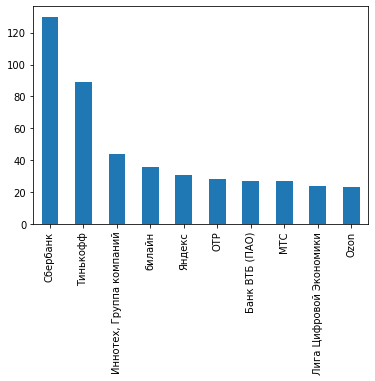

In [15]:
vacancy_df['employer_name'].value_counts().head(10).plot(kind='bar')

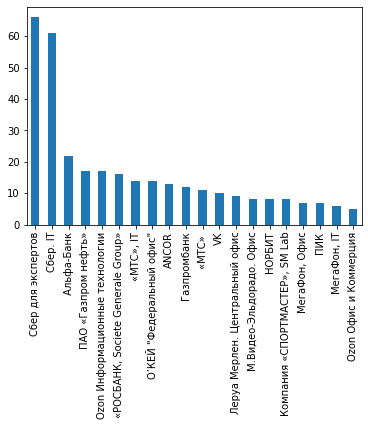

In [16]:
vacancy_df['depatment_name'].value_counts().head(20).plot(kind='bar')

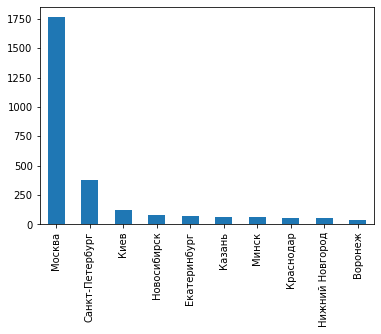

In [17]:
vacancy_df['city'].value_counts().head(10).plot(kind='bar')

Что с зарплатой

In [18]:
vacancy_df['salary_from'].isna().value_counts(normalize=True)

True     0.839784
False    0.160216
Name: salary_from, dtype: float64

In [19]:
vacancy_df['salary_to'].isna().value_counts(normalize=True)

True     0.88547
False    0.11453
Name: salary_to, dtype: float64

In [20]:
vacancy_df['salary_currency'].value_counts(normalize=True)

RUR    0.917492
USD    0.047855
KZT    0.013201
UAH    0.009901
EUR    0.004950
UZS    0.003300
BYR    0.001650
KGS    0.001650
Name: salary_currency, dtype: float64

In [21]:
salaries = vacancy_df.query("salary_currency == 'RUR' & experience in ['noExperience', 'between1and3']").groupby(['employer_name', 'depatment_name'])['salary_from'].agg('mean').reset_index()

In [40]:
salaries

,employer_name,depatment_name,salary_from
0,Альфа-Банк,Альфа-Банк,NaN
1,Леруа Мерлен,Леруа Мерлен. Центральный офис,45000.0
2,Сбербанк,Сбер для экспертов,70000.0
3,Сбербанк,Сбер. IT,100000.0
4,Спортмастер,"Компания «СПОРТМАСТЕР», Логистика",NaN


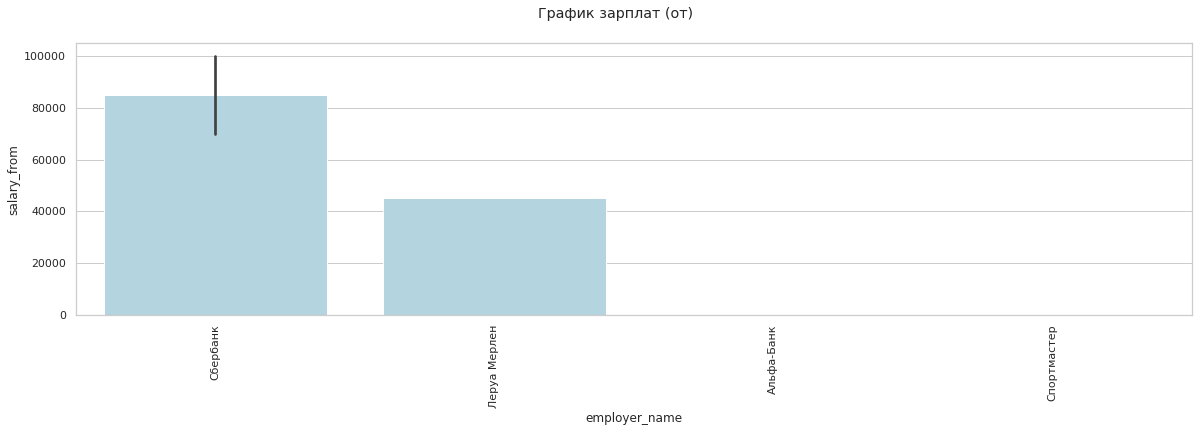

In [41]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,5))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)

Поиск вакансий

In [44]:
city_vacs = vacancy_df[vacancy_df['city'] == 'Новосибирск']
city_vacs.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,depatment_name,salary_from,salary_to,salary_gross,salary_currency,responses,city
20,52318071,False,Аналитик (Junior),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Киров...",None,None,2022-02-11T09:35:29+0300,2022-02-11T09:35:29+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52318071?host=hh.ru,https://hh.ru/vacancy/52318071,[],"{'id': '1092837', 'name': 'S7 IT', 'url': 'htt...",{'requirement': '...опыт работы в роли <highli...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 16},[],[],[],False,noExperience,S7 IT,NaN,NaN,NaN,NaN,NaN,16.0,Новосибирск
26,49612639,False,Bi Analyst (Junior),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Щетин...",None,None,2022-02-09T08:31:59+0300,2022-02-09T08:31:59+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/49612639?host=hh.ru,https://hh.ru/vacancy/49612639,[],"{'id': '1998846', 'name': 'Dankolab', 'url': '...",{'requirement': 'Знание <highlighttext>SQL</hi...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",{'responses': 49},[],[],[],False,noExperience,Dankolab,NaN,NaN,NaN,NaN,NaN,49.0,Новосибирск
77,52227861,False,Маркетолог-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-02-09T07:33:40+0300,2022-02-09T07:33:40+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52227861?host=hh.ru,https://hh.ru/vacancy/52227861,[],"{'id': '100685', 'name': 'Эко-фабрика «Сибирск...",{'requirement': 'Знание Power <highlighttext>B...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 6},[],[],[],False,noExperience,Эко-фабрика «Сибирский кедр»,NaN,NaN,NaN,NaN,NaN,6.0,Новосибирск


Посмотрим содержание вакансии:

In [45]:
vacs_df = city_vacs.copy().reset_index(drop=True).query('experience in ["noExperience", "between1And3"]')

In [46]:
vacs_df.head(2)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,depatment_name,salary_from,salary_to,salary_gross,salary_currency,responses,city
0,52318071,False,Аналитик (Junior),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Киров...",None,None,2022-02-11T09:35:29+0300,2022-02-11T09:35:29+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/52318071?host=hh.ru,https://hh.ru/vacancy/52318071,[],"{'id': '1092837', 'name': 'S7 IT', 'url': 'htt...",{'requirement': '...опыт работы в роли <highli...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 16},[],[],[],False,noExperience,S7 IT,NaN,NaN,NaN,NaN,NaN,16.0,Новосибирск
1,49612639,False,Bi Analyst (Junior),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Щетин...",None,None,2022-02-09T08:31:59+0300,2022-02-09T08:31:59+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/49612639?host=hh.ru,https://hh.ru/vacancy/49612639,[],"{'id': '1998846', 'name': 'Dankolab', 'url': '...",{'requirement': 'Знание <highlighttext>SQL</hi...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",{'responses': 49},[],[],[],False,noExperience,Dankolab,NaN,NaN,NaN,NaN,NaN,49.0,Новосибирск


In [47]:
vacs_df['url'].head()

0    https://api.hh.ru/vacancies/52318071?host=hh.ru
1    https://api.hh.ru/vacancies/49612639?host=hh.ru
2    https://api.hh.ru/vacancies/52227861?host=hh.ru
3    https://api.hh.ru/vacancies/46540480?host=hh.ru
4    https://api.hh.ru/vacancies/52234993?host=hh.ru
Name: url, dtype: object

Информацию из URL сохраним в читаемом виде:

In [48]:
HTML(json.loads(requests.get('https://api.hh.ru/vacancies/46873015?host=hh.ru').text)['description'])

In [49]:
vacs = vacs_df['url'].apply(lambda x: HTML(json.loads(requests.get(x).text)['description']))

In [50]:
vacs

0     <IPython.core.display.HTML object>
1     <IPython.core.display.HTML object>
2     <IPython.core.display.HTML object>
3     <IPython.core.display.HTML object>
4     <IPython.core.display.HTML object>
                     ...                
68    <IPython.core.display.HTML object>
69    <IPython.core.display.HTML object>
70    <IPython.core.display.HTML object>
71    <IPython.core.display.HTML object>
72    <IPython.core.display.HTML object>
Name: url, Length: 73, dtype: object

In [51]:
button = widgets.Button(description = 'Start')
output = widgets.Output()

display(button, output)

counter = 0
def on_clicked(b):
    with output:
      try:
        global counter
        clear_output()
        print('вакансии:', counter)
        display(HTML("<h1>" + str(vacs_df['name'][counter]) + ' в ' + str(vacs_df['employer_name'][counter]) + "</h1>"))
        display(vacs[counter])
        display(HTML('<a href="' + str(vacs_df['alternate_url'][counter]) + '" target="_blank">Ссылка на вакансию</a'))
        counter += 1
      except Exception as e:
        print('Вакансии закончились')

button.on_click(on_clicked)

Button(description='Start', style=ButtonStyle())

Output()